<a href="https://colab.research.google.com/github/PhamDucThinh1995/MixUp/blob/main/Mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

While the number of data we have is limited, we can always try to slightly alter the images and use them as ‘new’ samples to feed into the network for training. This process is called data augmentation.

In [18]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.1 MB/s 


In [29]:
!unzip './drive/MyDrive/Dataset/cifar-10-python.zip' -d cifar-10-python

Archive:  ./drive/MyDrive/Dataset/cifar-10-python.zip
   creating: cifar-10-python/cifar-10-python/
   creating: cifar-10-python/cifar-10-python/cifar-10-batches-py/
  inflating: cifar-10-python/cifar-10-python/cifar-10-batches-py/batches.meta  
  inflating: cifar-10-python/cifar-10-python/cifar-10-batches-py/data_batch_1  
  inflating: cifar-10-python/cifar-10-python/cifar-10-batches-py/data_batch_2  
  inflating: cifar-10-python/cifar-10-python/cifar-10-batches-py/data_batch_3  
  inflating: cifar-10-python/cifar-10-python/cifar-10-batches-py/data_batch_4  
  inflating: cifar-10-python/cifar-10-python/cifar-10-batches-py/data_batch_5  
 extracting: cifar-10-python/cifar-10-python/cifar-10-batches-py/readme.html  
  inflating: cifar-10-python/cifar-10-python/cifar-10-batches-py/test_batch  


In [42]:
"""
Import necessary libraries to train a network using mixup
The code is mainly developed using the PyTorch library
"""
import numpy as np
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pickle5 as pickle
import matplotlib.pyplot as plt
import torchvision.transforms.functional as VisionF
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
"""
Create a simple CNN
"""
class CNN(nn.Module):
   def __init__(self):
        super(CNN, self).__init__()

        # Network consists of 4 convolutional layers followed by 2 fully-connected layers
        self.conv11 = nn.Conv2d(3, 64, 3)
        self.conv12 = nn.Conv2d(64, 64, 3)
        self.conv21 = nn.Conv2d(64, 128, 3)
        self.conv22 = nn.Conv2d(128, 128, 3)
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)
   def forward(self, x):
       x = F.relu(self.conv11(x))
       x = F.relu(self.conv12(x))
       x = F.max_pool2d(x, (2,2))
       x = F.relu(self.conv21(x))
       x = F.relu(self.conv22(x))
       x = F.max_pool2d(x, (2,2))

       # Size is calculated based on kernel size 3 and padding 0
       x = x.view(-1, 128 * 5 * 5)
       x = F.relu(self.fc1(x))
       x = self.fc2(x)

       return nn.Sigmoid()(x)

In [5]:
"""
Dataset and Dataloader creation
All data are downloaded found via Graviti Open Dataset which links to CIFAR-10 official page
The dataset implementation is where mixup take place
"""

class CIFAR_Dataset(Dataset):
    def __init__(self, data_dir, train, transform):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []

        # Loading all the data depending on whether the dataset is training or testing
        if self.train:
            for i in range(5):
                with open(data_dir + 'data_batch_' + str(i+1), 'rb') as f:
                    entry = pickle.load(f, encoding='latin1')
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape it and turn it into the HWC format which PyTorch takes in the images
        # Original CIFAR format can be seen via its official page
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Create a one hot label
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.

        # Transform the image by converting to tensor and normalizing it
        if self.transform:
            image = transform(self.data[idx])

        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and idx%5 == 0:

            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.data)-1)
            mixup_label = torch.zeros(10)
            label[self.targets[mixup_idx]] = 1.
            if self.transform:
                mixup_image = transform(self.data[mixup_idx])

            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            image = lam * image + (1 - lam) * mixup_image
            label = lam * label + (1 - lam) * mixup_label

        return image, label

In [6]:
"""
Define the hyperparameters, image transform components, and the dataset/dataloaders
"""
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
BATCH_SIZE = 64
NUM_WORKERS = 4
LEARNING_RATE = 0.0001
NUM_EPOCHS = 30

In [33]:
train_dataset = CIFAR_Dataset('./cifar-10-python/cifar-10-python/cifar-10-batches-py/', 1, transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataset = CIFAR_Dataset('./cifar-10-python/cifar-10-python/cifar-10-batches-py/', 0, transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


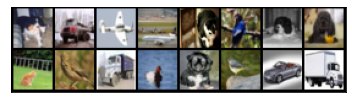

In [41]:
"""
Sketch train set for checking
"""
for x, labels in train_dataloader:
    img_grid = make_grid(x, normalize=True)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VisionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
show(img_grid)

In [34]:
"""
Initialize the network, loss Adam optimizer
Torch BCE Loss does not support mixup labels (not 1 or 0), so we implement our own
"""
net = CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))
best_Acc = 0

In [43]:
"""
Training Procedure
"""
for epoch in tqdm(range(NUM_EPOCHS)):
    net.train()
    # We train and visualize the loss every 100 iterations
    for idx, (imgs, labels) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = net(imgs)
        loss = bceloss(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%100 == 0:
            print("Epoch {} Iteration {}, Current Loss: {}".format(epoch, idx, loss))

    # We evaluate the network after every epoch based on test set accuracy
    net.eval()
    with torch.no_grad():
        total = 0
        numCorrect = 0
        for (imgs, labels) in test_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            preds = net(imgs)
            numCorrect += (torch.argmax(preds, dim=1) == torch.argmax(labels, dim=1)).float().sum()
            total += len(imgs)
        acc = numCorrect/total
        print("Current image classification accuracy at epoch {}: {}".format(epoch, acc))
        if acc > best_Acc:
            best_Acc = acc

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 Iteration 0, Current Loss: 0.6215993762016296
Epoch 0 Iteration 100, Current Loss: 0.308713436126709
Epoch 0 Iteration 200, Current Loss: 0.28920742869377136
Epoch 0 Iteration 300, Current Loss: 0.2912501394748688
Epoch 0 Iteration 400, Current Loss: 0.2732962965965271
Epoch 0 Iteration 500, Current Loss: 0.2803405523300171
Epoch 0 Iteration 600, Current Loss: 0.23884418606758118
Epoch 0 Iteration 700, Current Loss: 0.2545875906944275


  3%|▎         | 1/30 [07:24<3:34:45, 444.34s/it]

Current image classification accuracy at epoch 0: 0.41280001401901245
Epoch 1 Iteration 0, Current Loss: 0.2844898998737335
Epoch 1 Iteration 100, Current Loss: 0.2637230455875397
Epoch 1 Iteration 200, Current Loss: 0.2223728448152542
Epoch 1 Iteration 300, Current Loss: 0.24901774525642395
Epoch 1 Iteration 400, Current Loss: 0.2783224880695343
Epoch 1 Iteration 500, Current Loss: 0.28312867879867554
Epoch 1 Iteration 600, Current Loss: 0.2504960894584656
Epoch 1 Iteration 700, Current Loss: 0.2547345757484436


  7%|▋         | 2/30 [14:52<3:28:22, 446.51s/it]

Current image classification accuracy at epoch 1: 0.49070000648498535
Epoch 2 Iteration 0, Current Loss: 0.25710076093673706
Epoch 2 Iteration 100, Current Loss: 0.28151804208755493
Epoch 2 Iteration 200, Current Loss: 0.24739599227905273
Epoch 2 Iteration 300, Current Loss: 0.240218847990036
Epoch 2 Iteration 400, Current Loss: 0.21282026171684265
Epoch 2 Iteration 500, Current Loss: 0.20995894074440002
Epoch 2 Iteration 600, Current Loss: 0.23270630836486816
Epoch 2 Iteration 700, Current Loss: 0.227720707654953


 10%|█         | 3/30 [22:20<3:21:19, 447.38s/it]

Current image classification accuracy at epoch 2: 0.5335999727249146
Epoch 3 Iteration 0, Current Loss: 0.24032175540924072
Epoch 3 Iteration 100, Current Loss: 0.2310139387845993
Epoch 3 Iteration 200, Current Loss: 0.23391254246234894
Epoch 3 Iteration 300, Current Loss: 0.20273225009441376
Epoch 3 Iteration 400, Current Loss: 0.23507854342460632
Epoch 3 Iteration 500, Current Loss: 0.2413197010755539
Epoch 3 Iteration 600, Current Loss: 0.2183685004711151
Epoch 3 Iteration 700, Current Loss: 0.23544302582740784


 13%|█▎        | 4/30 [29:52<3:14:40, 449.23s/it]

Current image classification accuracy at epoch 3: 0.5565999746322632
Epoch 4 Iteration 0, Current Loss: 0.23773212730884552
Epoch 4 Iteration 100, Current Loss: 0.210092231631279
Epoch 4 Iteration 200, Current Loss: 0.18705829977989197
Epoch 4 Iteration 300, Current Loss: 0.21420595049858093
Epoch 4 Iteration 400, Current Loss: 0.16199621558189392
Epoch 4 Iteration 500, Current Loss: 0.1887945681810379
Epoch 4 Iteration 600, Current Loss: 0.20871317386627197
Epoch 4 Iteration 700, Current Loss: 0.2418026477098465


 17%|█▋        | 5/30 [37:20<3:06:52, 448.51s/it]

Current image classification accuracy at epoch 4: 0.5896999835968018
Epoch 5 Iteration 0, Current Loss: 0.2234864979982376
Epoch 5 Iteration 100, Current Loss: 0.220525860786438
Epoch 5 Iteration 200, Current Loss: 0.2373025119304657
Epoch 5 Iteration 300, Current Loss: 0.2020225077867508
Epoch 5 Iteration 400, Current Loss: 0.2267012596130371
Epoch 5 Iteration 500, Current Loss: 0.17398035526275635
Epoch 5 Iteration 600, Current Loss: 0.2118322104215622
Epoch 5 Iteration 700, Current Loss: 0.2048880159854889


 20%|██        | 6/30 [44:48<2:59:20, 448.36s/it]

Current image classification accuracy at epoch 5: 0.6115999817848206
Epoch 6 Iteration 0, Current Loss: 0.20844368636608124
Epoch 6 Iteration 100, Current Loss: 0.18116594851016998
Epoch 6 Iteration 200, Current Loss: 0.21233949065208435
Epoch 6 Iteration 300, Current Loss: 0.18967875838279724
Epoch 6 Iteration 400, Current Loss: 0.2191428691148758
Epoch 6 Iteration 500, Current Loss: 0.23659829795360565
Epoch 6 Iteration 600, Current Loss: 0.24542872607707977
Epoch 6 Iteration 700, Current Loss: 0.1974145472049713


 23%|██▎       | 7/30 [52:22<2:52:34, 450.21s/it]

Current image classification accuracy at epoch 6: 0.6261000037193298
Epoch 7 Iteration 0, Current Loss: 0.22733886539936066
Epoch 7 Iteration 100, Current Loss: 0.19159448146820068
Epoch 7 Iteration 200, Current Loss: 0.2097352296113968
Epoch 7 Iteration 300, Current Loss: 0.2151973694562912
Epoch 7 Iteration 400, Current Loss: 0.19487102329730988
Epoch 7 Iteration 500, Current Loss: 0.1850753128528595
Epoch 7 Iteration 600, Current Loss: 0.1611948311328888
Epoch 7 Iteration 700, Current Loss: 0.17290540039539337


 27%|██▋       | 8/30 [1:00:00<2:46:01, 452.78s/it]

Current image classification accuracy at epoch 7: 0.6499999761581421
Epoch 8 Iteration 0, Current Loss: 0.1984994113445282
Epoch 8 Iteration 100, Current Loss: 0.20850840210914612
Epoch 8 Iteration 200, Current Loss: 0.2138832062482834
Epoch 8 Iteration 300, Current Loss: 0.1959036886692047
Epoch 8 Iteration 400, Current Loss: 0.21663841605186462
Epoch 8 Iteration 500, Current Loss: 0.1911775916814804
Epoch 8 Iteration 600, Current Loss: 0.18402953445911407
Epoch 8 Iteration 700, Current Loss: 0.25411343574523926


 30%|███       | 9/30 [1:07:31<2:38:17, 452.25s/it]

Current image classification accuracy at epoch 8: 0.6456999778747559
Epoch 9 Iteration 0, Current Loss: 0.19142045080661774
Epoch 9 Iteration 100, Current Loss: 0.1565052568912506
Epoch 9 Iteration 200, Current Loss: 0.21734802424907684
Epoch 9 Iteration 300, Current Loss: 0.21570010483264923
Epoch 9 Iteration 400, Current Loss: 0.18648095428943634
Epoch 9 Iteration 500, Current Loss: 0.2036576271057129
Epoch 9 Iteration 600, Current Loss: 0.211943119764328
Epoch 9 Iteration 700, Current Loss: 0.2067091166973114


 33%|███▎      | 10/30 [1:15:08<2:31:14, 453.70s/it]

Current image classification accuracy at epoch 9: 0.6758999824523926
Epoch 10 Iteration 0, Current Loss: 0.16939198970794678
Epoch 10 Iteration 100, Current Loss: 0.1899549961090088
Epoch 10 Iteration 200, Current Loss: 0.1898105889558792
Epoch 10 Iteration 300, Current Loss: 0.16541239619255066
Epoch 10 Iteration 400, Current Loss: 0.18218564987182617
Epoch 10 Iteration 500, Current Loss: 0.15639638900756836
Epoch 10 Iteration 600, Current Loss: 0.21243174374103546
Epoch 10 Iteration 700, Current Loss: 0.17604906857013702


 37%|███▋      | 11/30 [1:22:45<2:23:56, 454.57s/it]

Current image classification accuracy at epoch 10: 0.6848999857902527
Epoch 11 Iteration 0, Current Loss: 0.18791571259498596
Epoch 11 Iteration 100, Current Loss: 0.18858042359352112
Epoch 11 Iteration 200, Current Loss: 0.1984725445508957
Epoch 11 Iteration 300, Current Loss: 0.18279165029525757
Epoch 11 Iteration 400, Current Loss: 0.1709456592798233
Epoch 11 Iteration 500, Current Loss: 0.19439087808132172
Epoch 11 Iteration 600, Current Loss: 0.18375638127326965
Epoch 11 Iteration 700, Current Loss: 0.15573713183403015


 40%|████      | 12/30 [1:30:20<2:16:27, 454.85s/it]

Current image classification accuracy at epoch 11: 0.6980999708175659
Epoch 12 Iteration 0, Current Loss: 0.14364738762378693
Epoch 12 Iteration 100, Current Loss: 0.16626368463039398
Epoch 12 Iteration 200, Current Loss: 0.20613279938697815
Epoch 12 Iteration 300, Current Loss: 0.1713830530643463
Epoch 12 Iteration 400, Current Loss: 0.1828707605600357
Epoch 12 Iteration 500, Current Loss: 0.17314009368419647
Epoch 12 Iteration 600, Current Loss: 0.1549655646085739
Epoch 12 Iteration 700, Current Loss: 0.1571311205625534


 43%|████▎     | 13/30 [1:37:54<2:08:49, 454.66s/it]

Current image classification accuracy at epoch 12: 0.7028999924659729
Epoch 13 Iteration 0, Current Loss: 0.17427359521389008
Epoch 13 Iteration 100, Current Loss: 0.16677387058734894
Epoch 13 Iteration 200, Current Loss: 0.18368187546730042
Epoch 13 Iteration 300, Current Loss: 0.17617031931877136
Epoch 13 Iteration 400, Current Loss: 0.19693568348884583
Epoch 13 Iteration 500, Current Loss: 0.1936788111925125
Epoch 13 Iteration 600, Current Loss: 0.18360480666160583
Epoch 13 Iteration 700, Current Loss: 0.16044878959655762


 47%|████▋     | 14/30 [1:45:28<2:01:09, 454.36s/it]

Current image classification accuracy at epoch 13: 0.7134000062942505
Epoch 14 Iteration 0, Current Loss: 0.18650001287460327
Epoch 14 Iteration 100, Current Loss: 0.17566312849521637
Epoch 14 Iteration 200, Current Loss: 0.1836787611246109
Epoch 14 Iteration 300, Current Loss: 0.16159966588020325
Epoch 14 Iteration 400, Current Loss: 0.14446914196014404
Epoch 14 Iteration 500, Current Loss: 0.17387770116329193
Epoch 14 Iteration 600, Current Loss: 0.1697586178779602
Epoch 14 Iteration 700, Current Loss: 0.18888795375823975


 50%|█████     | 15/30 [1:53:00<1:53:22, 453.53s/it]

Current image classification accuracy at epoch 14: 0.7141000032424927
Epoch 15 Iteration 0, Current Loss: 0.20922847092151642
Epoch 15 Iteration 100, Current Loss: 0.17181582748889923
Epoch 15 Iteration 200, Current Loss: 0.1536700278520584
Epoch 15 Iteration 300, Current Loss: 0.18061384558677673
Epoch 15 Iteration 400, Current Loss: 0.16980013251304626
Epoch 15 Iteration 500, Current Loss: 0.19201147556304932
Epoch 15 Iteration 600, Current Loss: 0.1763087958097458
Epoch 15 Iteration 700, Current Loss: 0.15267668664455414


 53%|█████▎    | 16/30 [2:00:33<1:45:48, 453.46s/it]

Current image classification accuracy at epoch 15: 0.7204999923706055
Epoch 16 Iteration 0, Current Loss: 0.17804798483848572
Epoch 16 Iteration 100, Current Loss: 0.18267908692359924
Epoch 16 Iteration 200, Current Loss: 0.15770752727985382
Epoch 16 Iteration 300, Current Loss: 0.16952137649059296
Epoch 16 Iteration 400, Current Loss: 0.20191772282123566
Epoch 16 Iteration 500, Current Loss: 0.145539790391922
Epoch 16 Iteration 600, Current Loss: 0.16242793202400208
Epoch 16 Iteration 700, Current Loss: 0.15001358091831207


 57%|█████▋    | 17/30 [2:08:02<1:37:59, 452.27s/it]

Current image classification accuracy at epoch 16: 0.7246000170707703
Epoch 17 Iteration 0, Current Loss: 0.19099409878253937
Epoch 17 Iteration 100, Current Loss: 0.16860322654247284
Epoch 17 Iteration 200, Current Loss: 0.17206044495105743
Epoch 17 Iteration 300, Current Loss: 0.16560626029968262
Epoch 17 Iteration 400, Current Loss: 0.15067893266677856
Epoch 17 Iteration 500, Current Loss: 0.13731373846530914
Epoch 17 Iteration 600, Current Loss: 0.16480275988578796
Epoch 17 Iteration 700, Current Loss: 0.1537967473268509


 60%|██████    | 18/30 [2:15:39<1:30:44, 453.69s/it]

Current image classification accuracy at epoch 17: 0.7315000295639038
Epoch 18 Iteration 0, Current Loss: 0.15826590359210968
Epoch 18 Iteration 100, Current Loss: 0.1406068503856659
Epoch 18 Iteration 200, Current Loss: 0.1464526355266571
Epoch 18 Iteration 300, Current Loss: 0.19537481665611267
Epoch 18 Iteration 400, Current Loss: 0.12382127344608307
Epoch 18 Iteration 500, Current Loss: 0.15336230397224426
Epoch 18 Iteration 600, Current Loss: 0.15578410029411316
Epoch 18 Iteration 700, Current Loss: 0.19219925999641418


 63%|██████▎   | 19/30 [2:23:15<1:23:16, 454.23s/it]

Current image classification accuracy at epoch 18: 0.745199978351593
Epoch 19 Iteration 0, Current Loss: 0.18971598148345947
Epoch 19 Iteration 100, Current Loss: 0.15419216454029083
Epoch 19 Iteration 200, Current Loss: 0.13357217609882355
Epoch 19 Iteration 300, Current Loss: 0.13852158188819885
Epoch 19 Iteration 400, Current Loss: 0.12914928793907166
Epoch 19 Iteration 500, Current Loss: 0.15049001574516296
Epoch 19 Iteration 600, Current Loss: 0.12941062450408936
Epoch 19 Iteration 700, Current Loss: 0.1466272920370102


 67%|██████▋   | 20/30 [2:30:50<1:15:44, 454.42s/it]

Current image classification accuracy at epoch 19: 0.7468000054359436
Epoch 20 Iteration 0, Current Loss: 0.14967504143714905
Epoch 20 Iteration 100, Current Loss: 0.1393076777458191
Epoch 20 Iteration 200, Current Loss: 0.14058007299900055
Epoch 20 Iteration 300, Current Loss: 0.15932248532772064
Epoch 20 Iteration 400, Current Loss: 0.15168753266334534
Epoch 20 Iteration 500, Current Loss: 0.1344834417104721
Epoch 20 Iteration 600, Current Loss: 0.16853958368301392
Epoch 20 Iteration 700, Current Loss: 0.11443110555410385


 70%|███████   | 21/30 [2:38:22<1:08:04, 453.88s/it]

Current image classification accuracy at epoch 20: 0.7469000220298767
Epoch 21 Iteration 0, Current Loss: 0.14242900907993317
Epoch 21 Iteration 100, Current Loss: 0.14395053684711456
Epoch 21 Iteration 200, Current Loss: 0.13729287683963776
Epoch 21 Iteration 300, Current Loss: 0.1890062391757965
Epoch 21 Iteration 400, Current Loss: 0.16195978224277496
Epoch 21 Iteration 500, Current Loss: 0.17514510452747345
Epoch 21 Iteration 600, Current Loss: 0.13797374069690704
Epoch 21 Iteration 700, Current Loss: 0.14529606699943542


 73%|███████▎  | 22/30 [2:45:53<1:00:24, 453.05s/it]

Current image classification accuracy at epoch 21: 0.7450000047683716
Epoch 22 Iteration 0, Current Loss: 0.14406749606132507
Epoch 22 Iteration 100, Current Loss: 0.13172048330307007
Epoch 22 Iteration 200, Current Loss: 0.1438838243484497
Epoch 22 Iteration 300, Current Loss: 0.1396012008190155
Epoch 22 Iteration 400, Current Loss: 0.12715579569339752
Epoch 22 Iteration 500, Current Loss: 0.14269569516181946
Epoch 22 Iteration 600, Current Loss: 0.20941376686096191
Epoch 22 Iteration 700, Current Loss: 0.12604740262031555


 77%|███████▋  | 23/30 [2:53:28<52:53, 453.40s/it]  

Current image classification accuracy at epoch 22: 0.7483000159263611
Epoch 23 Iteration 0, Current Loss: 0.14174701273441315
Epoch 23 Iteration 100, Current Loss: 0.12778176367282867
Epoch 23 Iteration 200, Current Loss: 0.17684732377529144
Epoch 23 Iteration 300, Current Loss: 0.16335810720920563
Epoch 23 Iteration 400, Current Loss: 0.13258624076843262
Epoch 23 Iteration 500, Current Loss: 0.14462615549564362
Epoch 23 Iteration 600, Current Loss: 0.1480758786201477
Epoch 23 Iteration 700, Current Loss: 0.15422400832176208


 80%|████████  | 24/30 [3:01:03<45:24, 454.00s/it]

Current image classification accuracy at epoch 23: 0.7454000115394592
Epoch 24 Iteration 0, Current Loss: 0.16961732506752014
Epoch 24 Iteration 100, Current Loss: 0.12379877269268036
Epoch 24 Iteration 200, Current Loss: 0.11448973417282104
Epoch 24 Iteration 300, Current Loss: 0.17192012071609497
Epoch 24 Iteration 400, Current Loss: 0.1043846607208252
Epoch 24 Iteration 500, Current Loss: 0.1265788972377777
Epoch 24 Iteration 600, Current Loss: 0.1412481963634491
Epoch 24 Iteration 700, Current Loss: 0.1285402476787567


 83%|████████▎ | 25/30 [3:08:36<37:48, 453.69s/it]

Current image classification accuracy at epoch 24: 0.755299985408783
Epoch 25 Iteration 0, Current Loss: 0.13033293187618256
Epoch 25 Iteration 100, Current Loss: 0.1829276829957962
Epoch 25 Iteration 200, Current Loss: 0.14046502113342285
Epoch 25 Iteration 300, Current Loss: 0.16157525777816772
Epoch 25 Iteration 400, Current Loss: 0.11927898228168488
Epoch 25 Iteration 500, Current Loss: 0.12183699756860733
Epoch 25 Iteration 600, Current Loss: 0.12350732088088989
Epoch 25 Iteration 700, Current Loss: 0.13830411434173584


 87%|████████▋ | 26/30 [3:16:08<30:12, 453.12s/it]

Current image classification accuracy at epoch 25: 0.7587000131607056
Epoch 26 Iteration 0, Current Loss: 0.13265055418014526
Epoch 26 Iteration 100, Current Loss: 0.11186107248067856
Epoch 26 Iteration 200, Current Loss: 0.14866788685321808
Epoch 26 Iteration 300, Current Loss: 0.15347930788993835
Epoch 26 Iteration 400, Current Loss: 0.12838701903820038
Epoch 26 Iteration 500, Current Loss: 0.10552271455526352
Epoch 26 Iteration 600, Current Loss: 0.15671490132808685
Epoch 26 Iteration 700, Current Loss: 0.14169399440288544


 90%|█████████ | 27/30 [3:23:40<22:38, 452.72s/it]

Current image classification accuracy at epoch 26: 0.7505000233650208
Epoch 27 Iteration 0, Current Loss: 0.1528582125902176
Epoch 27 Iteration 100, Current Loss: 0.14230182766914368
Epoch 27 Iteration 200, Current Loss: 0.12204679101705551
Epoch 27 Iteration 300, Current Loss: 0.1389468014240265
Epoch 27 Iteration 400, Current Loss: 0.1275753527879715
Epoch 27 Iteration 500, Current Loss: 0.1532827913761139
Epoch 27 Iteration 600, Current Loss: 0.10741255432367325
Epoch 27 Iteration 700, Current Loss: 0.13728627562522888


 93%|█████████▎| 28/30 [3:31:08<15:02, 451.39s/it]

Current image classification accuracy at epoch 27: 0.7608000040054321
Epoch 28 Iteration 0, Current Loss: 0.13066013157367706
Epoch 28 Iteration 100, Current Loss: 0.14677481353282928
Epoch 28 Iteration 200, Current Loss: 0.13102488219738007
Epoch 28 Iteration 300, Current Loss: 0.13511154055595398
Epoch 28 Iteration 400, Current Loss: 0.13530483841896057
Epoch 28 Iteration 500, Current Loss: 0.13411790132522583
Epoch 28 Iteration 600, Current Loss: 0.11081858724355698
Epoch 28 Iteration 700, Current Loss: 0.15287603437900543


 97%|█████████▋| 29/30 [3:38:39<07:31, 451.21s/it]

Current image classification accuracy at epoch 28: 0.7533000111579895
Epoch 29 Iteration 0, Current Loss: 0.13089613616466522
Epoch 29 Iteration 100, Current Loss: 0.15026836097240448
Epoch 29 Iteration 200, Current Loss: 0.09355700016021729
Epoch 29 Iteration 300, Current Loss: 0.163484126329422
Epoch 29 Iteration 400, Current Loss: 0.18654945492744446
Epoch 29 Iteration 500, Current Loss: 0.12335287034511566
Epoch 29 Iteration 600, Current Loss: 0.14263980090618134
Epoch 29 Iteration 700, Current Loss: 0.14093858003616333


100%|██████████| 30/30 [3:46:09<00:00, 452.33s/it]

Current image classification accuracy at epoch 29: 0.7583000063896179


In [44]:
"""
Printing out overall best result
"""
print("Best Result: {}".format(best_Acc))

Best Result: 0.7608000040054321
